###  Module & Utility Imports

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.lines as mlines


### Load Evaluation Summary Tables from 'EvalResults/SummaryTables/' Directory


In [2]:
# Define the input directory
input_dir = './EvalResults/SummaryTables/'

# Load each summary table from CSV
AnalAccMItable = pd.read_csv(os.path.join(input_dir, 'AnalAccMItable.csv'))
SenseAccMItable = pd.read_csv(os.path.join(input_dir, 'SenseAccMItable.csv'))
BenchAnalAccMItable = pd.read_csv(os.path.join(input_dir, 'BenchAnalAccMItable.csv'))
AblaAccMItable = pd.read_csv(os.path.join(input_dir, 'AblaAccMItable.csv'))

### Generate Radar Charts for Sensitivity Analysis Metrics with Preprocessing and Styling

In [22]:
# ---------------------------
# 1. Normalization Function
# ---------------------------
def normalize_metrics(df, metric_list, group_min_max):
    """
    Normalize the specified metrics in the target DataFrame using group-specific minimum
    and maximum values computed for each group defined by ['Type', 'Source'].
    """
    df_norm = df.copy()
    for group_key, group_df in df_norm.groupby(['Type', 'Source']):
        min_max = group_min_max.get(group_key, {})
        for metric in metric_list:
            if metric in min_max:
                gmin, gmax = min_max[metric]
                if gmax > gmin:
                    df_norm.loc[group_df.index, metric] = (
                        group_df[metric] - gmin
                    ) / (gmax - gmin)
                else:
                    df_norm.loc[group_df.index, metric] = 0.0
    return df_norm

# ---------------------------
# 2. Data Preprocessing Function
# ---------------------------
def preprocess_data(raw_df, rename_map, extra_vars, metrics_short, global_min_max):
    """
    Preprocess the raw evaluation DataFrame by renaming metric columns, grouping by
    additional variables, applying global normalization, and melting for radar chart plotting.
    """
    data = raw_df.rename(columns=rename_map).copy()
    grouping_columns = ['Type', 'Source'] + extra_vars
    data_grouped = data.groupby(grouping_columns).mean(numeric_only=True).reset_index()
    data_grouped = normalize_metrics(data_grouped, metrics_short, global_min_max)
    df_melted = pd.melt(
        data_grouped,
        id_vars=grouping_columns,
        value_vars=metrics_short,
        var_name='Metric',
        value_name='Value'
    )
    return data_grouped, df_melted

# ---------------------------
# 3. Radar Chart Plotting Function (with legend controls)
# ---------------------------
def plot_radar_charts(
    df_melted,
    metrics_short,
    metric_maps,
    extra_vars,
    ls_list,
    font_size=14,
    title_font_size=15,
    legend_font_size=12,
    wspace=0.55,
    hspace=0.35,
    #
    # 새로 추가된 파라미터
    fig_size=(14, 6),
    legend_row_index=1,         # 0-based: 두 번째 row 에 legend
    legend_ncol=1,              # legend columns 수
    legend_loc='center',
    legend_bbox=(0.65, 0.45),
):
    types = sorted(df_melted['Type'].unique())
    n_rows = len(types)
    n_cols = len(extra_vars)
    
    fig = plt.figure(figsize=fig_size, constrained_layout=True)
    outer = gridspec.GridSpec(n_rows, n_cols, wspace=wspace, hspace=hspace)
    
    for i, typ in enumerate(types):
        df_type = df_melted[df_melted['Type'] == typ]
        for j, extra in enumerate(extra_vars):
            df_subset = df_type[['Source', extra, 'Metric', 'Value']].dropna(subset=[extra])
            if df_subset.empty:
                continue
            
            pivot_df = (
                df_subset
                .pivot_table(index=['Source', extra], columns='Metric', values='Value')
                .reset_index()
            )
            for m in metrics_short:
                if m not in pivot_df.columns:
                    pivot_df[m] = np.nan
            pivot_df = pivot_df[['Source', extra] + metrics_short]
            
            unique_levels = sorted(df_subset[extra].unique())
            cmap = plt.get_cmap('tab10')
            extra_color_map = {
                lvl: mcolors.to_hex(cmap(idx / len(unique_levels)))
                for idx, lvl in enumerate(unique_levels)
            }
            
            ax = fig.add_subplot(outer[i, j], projection='polar')
            num_metrics = len(metrics_short)
            angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
            angles += angles[:1]
            ax.set_ylim(0, 1.0)
            ax.tick_params(axis='y', labelleft=False)
            ax.grid(True, zorder=10, color='gray', linestyle='-', linewidth=1.5, alpha=0.7)
            ax.yaxis.set_zorder(1000)
            
            # Highlight sector
            i_idx = metrics_short.index('(i)')
            iii_idx = metrics_short.index('(iii)')
            angle1 = angles[i_idx]
            angle2 = angles[iii_idx] + (2*np.pi if angles[iii_idx] < angle1 else 0)
            highlight_angles = np.concatenate([[angle1], np.linspace(angle1, angle2, 100), [angle2]])
            highlight_radius = np.concatenate([[0], np.ones(100)*1.1, [0]])
            ax.fill(
                highlight_angles,
                highlight_radius,
                color='gold',
                hatch='///',
                edgecolor='orange',
                alpha=0.15,
                linewidth=0.0,
                zorder=0
            )
            
            # Plot each line
            unique_sources = sorted(pivot_df['Source'].unique())
            for idx, row in pivot_df.iterrows():
                values = [row[m] for m in metrics_short] + [row[metrics_short[0]]]
                color = extra_color_map.get(row[extra], 'gray')
                ls = ls_list[unique_sources.index(row['Source']) % len(ls_list)]
                ax.plot(angles, values, marker='o', linestyle=ls, color=color,
                        label=f"{row['Source']} ({extra}: {row[extra]})",
                        linewidth=1., markersize=5, alpha=0.5)
                ax.fill(angles, values, color=color, alpha=0.25)
            
            ax.set_xticks(angles[:-1])
            labels = ax.set_xticklabels([metric_maps[m] for m in metrics_short], fontsize=font_size)
            for lbl, ang in zip(labels, angles[:-1]):
                deg = np.degrees(ang)
                ha = 'right' if 90 <= deg <= 270 else 'left'
                lbl.set_horizontalalignment(ha)
                lbl.set_verticalalignment('center')
            
            # Title and Type label
            display_extra = {
                'Depth': r'$\boldsymbol{\zeta}$',
                'LatDim': r'$\boldsymbol{J}$',
                'Comp': r'$\boldsymbol{C}$'
            }.get(extra, extra)
            ax.set_title(display_extra, fontsize=title_font_size+1, pad=0)
            if j == 0:
                display_type = 'ABP' if typ=='ART' else ('ECG' if typ=='II' else typ)
                ax.text(-0.35, 0.5, display_type, transform=ax.transAxes,
                        fontsize=title_font_size+3, fontweight='bold', va='center', ha='center')
            
            # Legend: only on specified row
            if i == legend_row_index:
                leg = ax.legend(
                    fontsize=legend_font_size,
                    loc=legend_loc,
                    bbox_to_anchor=legend_bbox,
                    columnspacing=1.5,
                    ncol=legend_ncol,
                    borderaxespad=0.3
                )
                
                for text in leg.get_texts():
                    txt = text.get_text()
                    for key, sym in legend_map.items():
                        if key in txt:
                            txt = txt.replace(key, sym)
                    text.set_text(txt)
    
    plt.savefig('./PaperWork/Figures/SensitivityAcrossParameters.png',
                dpi=300, bbox_inches='tight')
    plt.show()



### ① Visualization of Metric Sensitivity Across Model Parameters

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_37528\362774256.py:173: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('./PaperWork/Figures/SensitivityAcrossParameters.png',
C:\Users\User\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


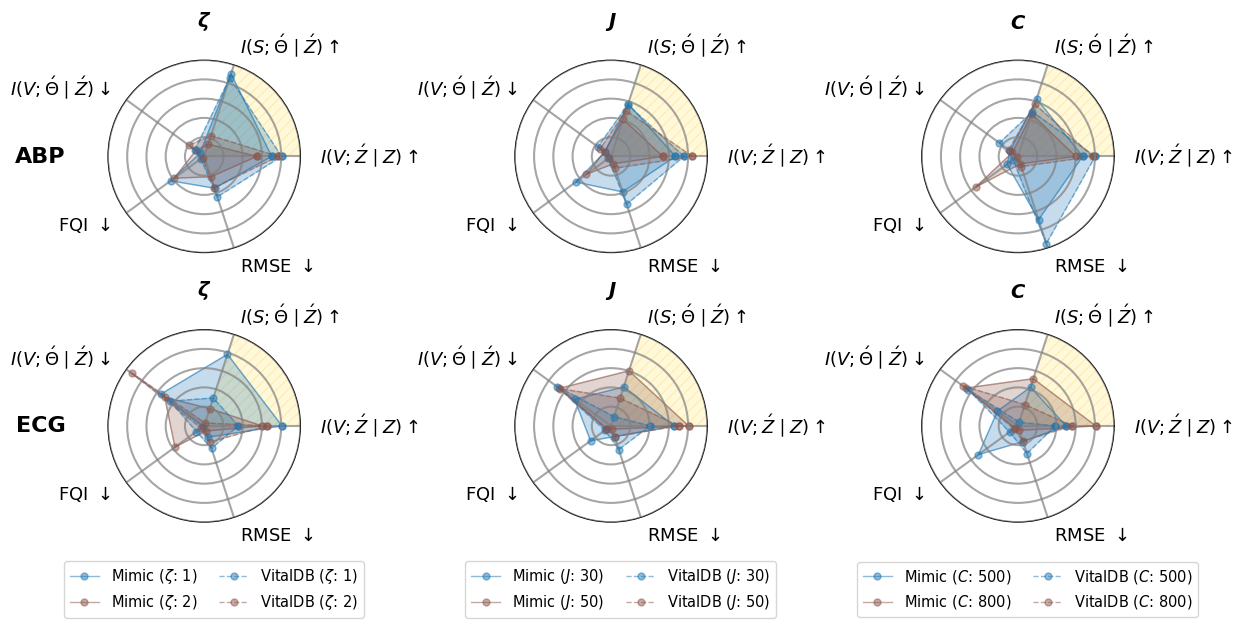

In [23]:
# Metric and Column Settings
metrics_original = [
    '(i) $I(V; \\acute{Z} \\mid Z)$',
    '(iii) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$',
    '(ii) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$',
    'FQI',
    'RMSE'
]

metric_maps = {
    '(i)': '$I(V; \\acute{Z} \\mid Z) \\uparrow$',
    '(iii)': '$I(S;\\acute{\\Theta} \\mid \\acute{Z}) \\uparrow$',
    '(ii)': '$I(V;\\acute{\\Theta} \\mid \\acute{Z}) \\downarrow$',
    'FQI': 'FQI $\\downarrow$',
    'RMSE': 'RMSE $\\downarrow$'
}

legend_map = {
    'Depth': r'$\zeta$',
    'LatDim': r'$J$',
    'Comp': r'$C$'
}

extra_vars = ['Depth', 'LatDim', 'Comp']
metrics_short = ['(i)', '(iii)', '(ii)', 'FQI', 'RMSE']


# Define style parameters for the radar chart
FONT_SIZE = 13
TITLE_FONT_SIZE = 13
LEGEND_FONT_SIZE = 10.5
WSPACE = 0.5
HSPACE = 0.4
ls_list = ['-', '--', '-.', ':']


# Mapping from original metric names to short names.
rename_map = dict(zip(metrics_original, metrics_short))

# Apply the renaming so that each DataFrame has columns with the short names.
AnalAccMItable_renamed = AnalAccMItable.rename(columns=rename_map)
SenseAccMItable_renamed = SenseAccMItable.rename(columns=rename_map)
BenchAnalAccMItable_renamed = BenchAnalAccMItable.rename(columns=rename_map)
AblaAccMItable_renamed = AblaAccMItable.rename(columns=rename_map)

# Combine all four DataFrames. Now each one should have the columns as in metrics_short.
all_dfs = pd.concat([
    AnalAccMItable_renamed,
    SenseAccMItable_renamed,
    #BenchAnalAccMItable_renamed,
    AblaAccMItable_renamed])


# Compute Global Minimum and Maximum ---
group_min_max = {}
for group_key, group_data in all_dfs.groupby(['Type', 'Source']):
    # group_key is a tuple of (Type, Source)
    group_min_max[group_key] = {}
    for metric in metrics_short:
        gmin = group_data[metric].min()
        gmax = group_data[metric].max()
        group_min_max[group_key][metric] = (gmin, gmax)

# Preprocess the data: rename metrics, group by parameters, and normalize.
data_grouped, df_melted = preprocess_data(SenseAccMItable, rename_map, extra_vars, metrics_short, group_min_max)

# Generate the radar charts using the preprocessed melted DataFrame
plot_radar_charts(
    df_melted,
    metrics_short,
    metric_maps,
    extra_vars,
    ls_list,
    font_size=FONT_SIZE,
    title_font_size=TITLE_FONT_SIZE,
    legend_font_size=LEGEND_FONT_SIZE,
    wspace=WSPACE,
    hspace=HSPACE,
    legend_bbox=(0.55, -0.35),
    legend_ncol=2)

### Generate Radar Charts for Ablation Study Metrics 

In [15]:
# -----------------------------------------------------------------------------
# 1. Helper Function to Shorten Ablation Model Names for the Legend
# -----------------------------------------------------------------------------
def shorten_ablation_model_name(model_name):
    """
    Simplifies the ablation model name by returning the first segment before '_'.
    Assumes model names follow a structured format like 'SKZFC_ART_1_50_800'.

    Parameters:
        model_name (str): Full ablation model name.

    Returns:
        str: Simplified label (e.g., '$\\theta$').
    """
    prefix = model_name.split("_")[0]
    
    if prefix == 'FC':
        return r'$\theta$'
    elif prefix == 'SKZ':
        return r'$Z$'
    else:
        return prefix


# -----------------------------------------------------------------------------
# 2. Radar Chart Plotting Functions
# -----------------------------------------------------------------------------
def plot_radar_subplot(ax, data, metrics, main_models, main_color):
    """
    Draws a radar chart on the provided polar Axes for the given (Type, Source) subset.
    
    Main models are drawn with a unified solid line (main_color), and ablation models
    are drawn with dotted lines using distinct colors drawn from a custom palette.
    
    Additionally, the function highlights the sector between metrics '(i)' and '(iii)'.
    The x-axis tick labels are set via metric_maps and aligned based on the angle.

    Parameters:
        ax (Axes): The matplotlib polar Axes on which to plot.
        data (DataFrame): Evaluation data for one (Type, Source) combination.
        metrics (list): List of final display metric names (the x-axis tick labels).
        main_models (list): List of model names considered main.
        main_color (str): The unified color for all main models.
    """
    # Compute angles based on number of metrics
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    # radial axis settings
    ax.set_ylim(0, 1.0)
    #ax.tick_params(axis='y', labelsize=FONT_SIZE)
    ax.tick_params(axis='y', labelleft=False)
    ax.grid(True, zorder=10, color='gray', linestyle='-', linewidth=1., alpha=0.7)
    ax.yaxis.set_zorder(200)

    # -------------------------
    # Highlight sector between (i) and (iii)
    # -------------------------
    i_idx = metrics_short.index('(i)')
    iii_idx = metrics_short.index('(iii)')
    angle1 = angles[i_idx]
    angle2 = angles[iii_idx]
    if angle2 < angle1:
        angle2 += 2 * np.pi
    highlight_angles = np.concatenate([
        [angle1],
        np.linspace(angle1, angle2, 100),
        [angle2]
    ])
    highlight_radius = np.concatenate([
        [0],
        np.ones(100) * 1.1,
        [0]
    ])
    ax.fill(
        highlight_angles,
        highlight_radius,
        color='gold',
        hatch='///',
        edgecolor='orange',
        alpha=0.15,
        linewidth=0.0,
        zorder=0
    )

    # ------------------------------------
    # Plot each model's line & fill area
    # ------------------------------------
    ablation_models = data.loc[~data['Model'].isin(main_models), 'Model'].unique()
    palette = ['brown', 'darkgreen', 'purple', 'teal', 
               'goldenrod', 'cornflowerblue', 'indigo', 
               'darkorange', 'slateblue']
    color_map = {m: palette[i % len(palette)] for i, m in enumerate(ablation_models)}

    seen_labels = set()
    for _, row in data.iterrows():
        model_name = row['Model']
        vals = [row[m] for m in metrics] + [row[metrics[0]]]

        if model_name in main_models:
            color, ls, fill_a, marker, lbl = main_color, '-', 0.25, 'D', "Ours"
        else:
            color = color_map.get(model_name, 'black')
            ls, fill_a, marker = ':', 0.1, 'o'
            lbl = shorten_ablation_model_name(model_name)

        legend_tag = lbl if lbl not in seen_labels else '_nolegend_'
        seen_labels.add(lbl)

        ax.plot(angles, vals, color=color, linestyle=ls, marker=marker, label=legend_tag, alpha=0.5)
        ax.fill(angles, vals, color=color, alpha=fill_a)

    # set the metric labels around the chart
    ax.set_xticks(angles[:-1])
    labels = ax.set_xticklabels([metric_maps[s] for s in metrics_short], 
                                fontsize=FONT_SIZE+2)
    ax.tick_params(axis='x', pad=TICK_LABEL_PAD, labelsize=FONT_SIZE+3)
    for lbl, ang in zip(labels, angles[:-1]):
        deg = np.degrees(ang)
        if 90 <= deg <= 270:
            lbl.set_horizontalalignment('right')
        else:
            lbl.set_horizontalalignment('left')
        lbl.set_verticalalignment('center')


def plot_radar_grid(evaluation_df, metrics, main_models, main_color, figname, legend_ncol=3):
    """
    Creates a grid of radar charts (1×up-to-4 layout) with a SINGLE shared legend.
    """
    # select up to 4 (Type, Source) groups
    groups = evaluation_df[['Type', 'Source']].drop_duplicates().values.tolist()[:4]
    n = len(groups)

    fig, axes = plt.subplots(1, n, subplot_kw=dict(projection='polar'),  figsize=(n * 6, 5))
    if n == 1:
        axes = [axes]
    fig.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
    
    for ax, (typ, src) in zip(axes, groups):
        subset = evaluation_df[(evaluation_df['Type'] == typ) & 
                               (evaluation_df['Source'] == src)]
        if subset.empty:
            ax.set_visible(False)
            continue

        plot_radar_subplot(ax, subset, metrics, main_models, main_color)
        label_typ = 'ABP' if typ == 'ART' else 'ECG' if typ == 'II' else typ
        ax.set_title(f"{label_typ} from {src}",
                     fontsize=TITLE_FONT_SIZE, pad=10, fontweight='bold')

        # remove any individual legend if present
        legend = ax.get_legend()
        if legend:
            legend.remove()

    # shared legend for the whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, .1),
               ncol=legend_ncol,
               fontsize=LEGEND_FONT_SIZE,
               frameon=True)

    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'./PaperWork/Figures/{figname}.png', dpi=300, bbox_inches='tight')
    plt.show()



### ② Visualization of Metric Sensitivity Across Ablation Models

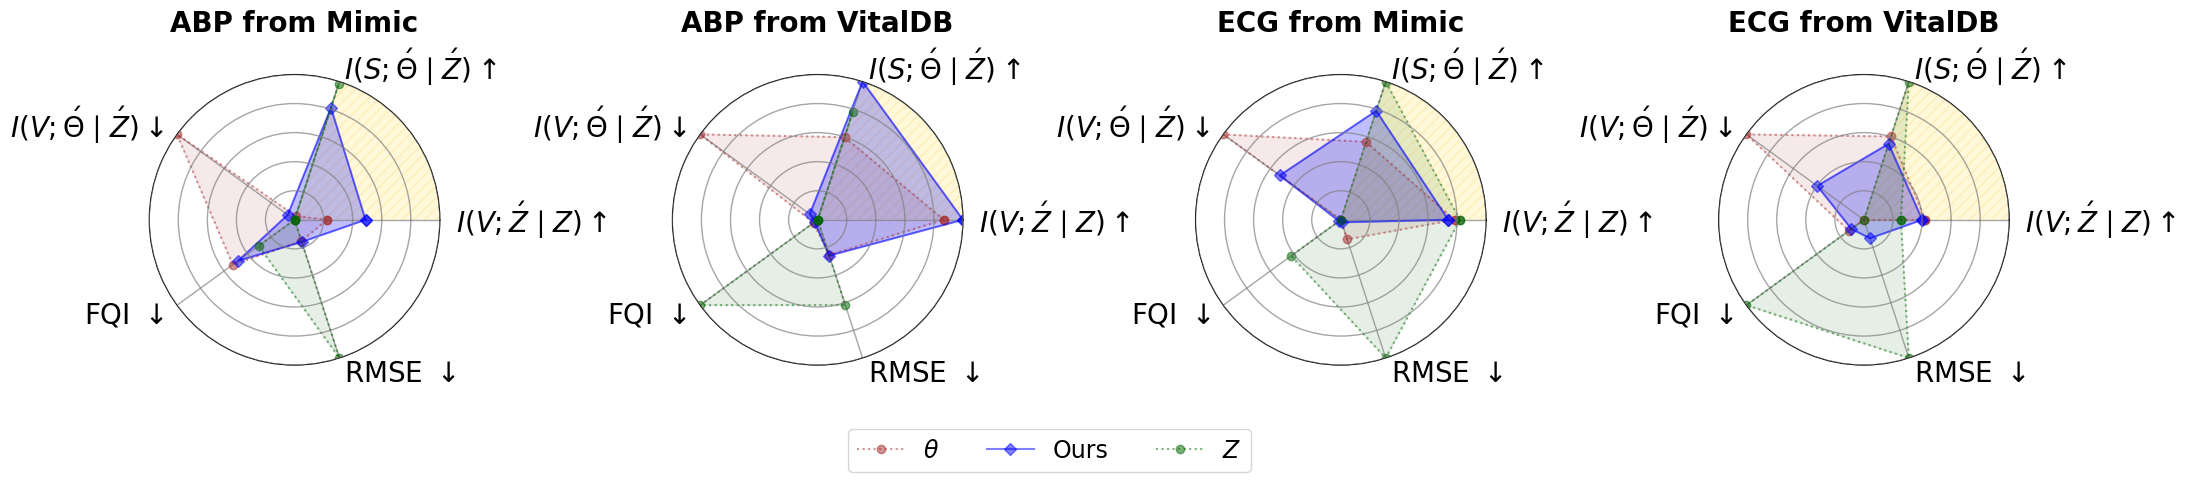

In [16]:
# -----------------------------------------------------------------------------
# 3. Metric & Column Setup
# -----------------------------------------------------------------------------
FONT_SIZE        = 17
TITLE_FONT_SIZE  = 20
LEGEND_FONT_SIZE  = 17   
WSPACE           = 0.8
HSPACE           = 0.0
TICK_LABEL_PAD   = 1
main_color       = 'blue'

main_models = [
    'SKZFC_ART_1_50_800_Mimic',
    'SKZFC_ART_1_50_800_VitalDB',
    'SKZFC_II_1_50_800_Mimic',
    'SKZFC_II_1_50_800_VitalDB'
]

metrics_original = [
    '(i) $I(V; \\acute{Z} \\mid Z)$',
    '(iii) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$',
    '(ii) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$',
    'FQI',
    'RMSE'
]
metrics_short = ['(i)', '(iii)', '(ii)', 'FQI', 'RMSE']
rename_map   = dict(zip(metrics_original, metrics_short))
metric_maps  = {
    '(i)':   '$I(V; \\acute{Z} \\mid Z) \\uparrow$',
    '(iii)': '$I(S;\\acute{\\Theta} \\mid \\acute{Z}) \\uparrow$',
    '(ii)':  '$I(V;\\acute{\\Theta} \\mid \\acute{Z}) \\downarrow$',
    'FQI':   'FQI $\\downarrow$',
    'RMSE':  'RMSE $\\downarrow$'
}

# rename and normalize
AnalAccMItable_renamed   = AnalAccMItable.rename(columns=rename_map)
SenseAccMItable_renamed  = SenseAccMItable.rename(columns=rename_map)
AblaAccMItable_renamed   = AblaAccMItable.rename(columns=rename_map)

all_dfs = pd.concat([
    AnalAccMItable_renamed,
    SenseAccMItable_renamed,
    AblaAccMItable_renamed
])

# compute per-(Type,Source) mins & maxs
group_min_max = {}
for key, grp in all_dfs.groupby(['Type', 'Source']):
    group_min_max[key] = {
        m: (grp[m].min(), grp[m].max())
        for m in metrics_short
    }

# normalize & map final metric names
data = AblaAccMItable.copy().rename(columns=rename_map)
data = normalize_metrics(data, metrics_short, group_min_max)
data = data.rename(columns=metric_maps)
radar_metrics = list(metric_maps.values())

# plot
plot_radar_grid(data, radar_metrics, main_models, main_color, figname='SensitivityAcrossAblation')

### ③ Visualization of Metric Sensitivity Across Main and Benchmark Models

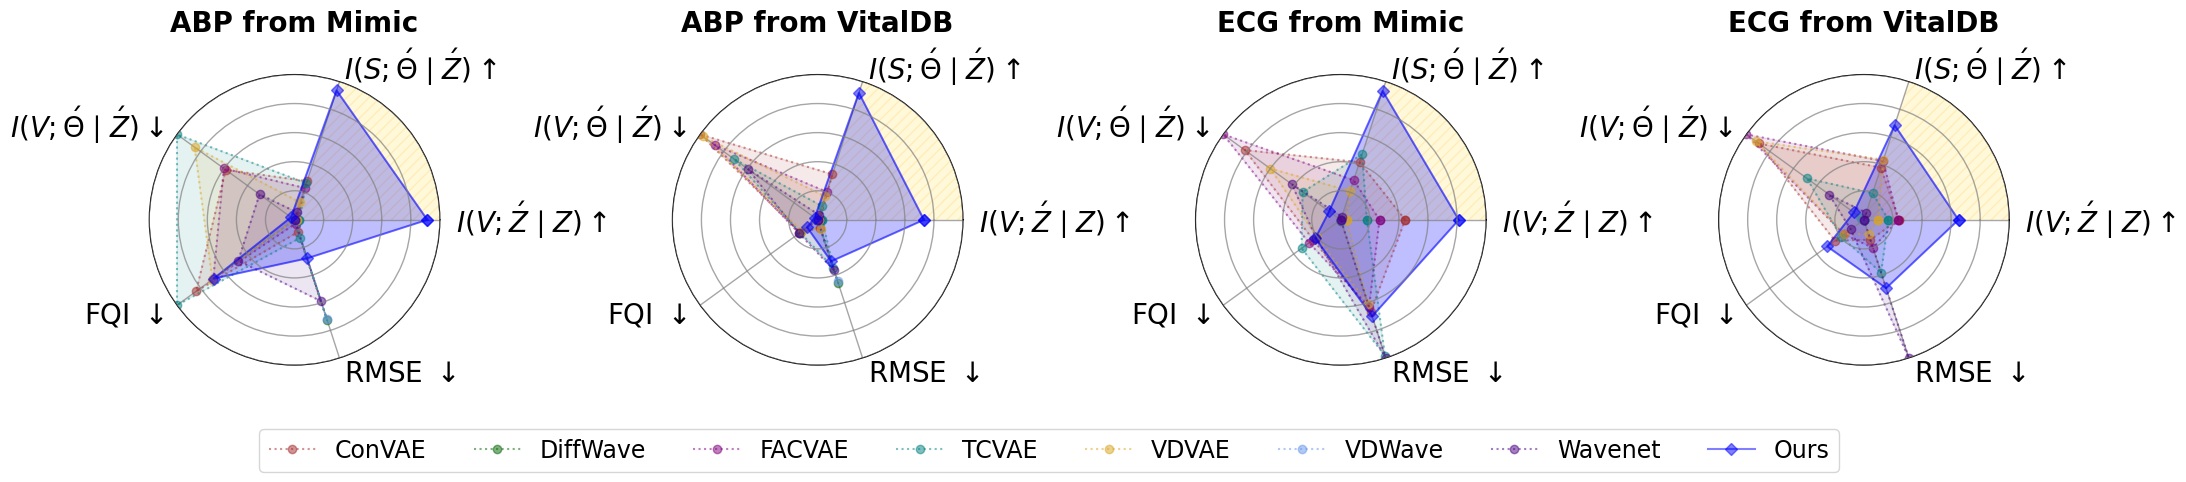

In [17]:
FONT_SIZE         = 17
TITLE_FONT_SIZE   = 20
LEGEND_FONT_SIZE  = 17   
WSPACE            = 0.8  
HSPACE            = 0.0
TICK_LABEL_PAD    = 1
main_color        = 'blue'

main_models = [
    'SKZFC_ART_1_30_800_Mimic',
    'SKZFC_ART_1_30_800_VitalDB',
    'SKZFC_II_1_30_800_Mimic',
    'SKZFC_II_1_30_800_VitalDB'
]

metrics_original = [
    '(i) $I(V; \\acute{Z} \\mid Z)$',
    '(iii) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$',
    '(ii) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$',
    'FQI','RMSE'
]
metrics_short = ['(i)','(iii)','(ii)','FQI','RMSE']
rename_map   = dict(zip(metrics_original, metrics_short))
metric_maps  = {
    '(i)':   '$I(V; \\acute{Z} \\mid Z) \\uparrow$',
    '(iii)': '$I(S;\\acute{\\Theta} \\mid \\acute{Z}) \\uparrow$',
    '(ii)':  '$I(V;\\acute{\\Theta} \\mid \\acute{Z}) \\downarrow$',
    'FQI':   'FQI $\\downarrow$',
    'RMSE':  'RMSE $\\downarrow$'
}

# rename each table
AnalAccMItable_renamed   = AnalAccMItable.rename(columns=rename_map)
SenseAccMItable_renamed  = SenseAccMItable.rename(columns=rename_map)
BenchAnalAccMItable_renamed = BenchAnalAccMItable.rename(columns=rename_map)
AblaAccMItable_renamed   = AblaAccMItable.rename(columns=rename_map)

# combine for normalization
all_dfs = pd.concat([
    AnalAccMItable_renamed,
    SenseAccMItable_renamed,
    BenchAnalAccMItable_renamed,
    AblaAccMItable_renamed
])

# compute min/max per group
group_min_max = {}
for key, grp in all_dfs.groupby(['Type','Source']):
    group_min_max[key] = {
        m: (grp[m].min(), grp[m].max())
        for m in metrics_short
    }

# normalize Bench dataset
data = BenchAnalAccMItable.copy().rename(columns=rename_map)
data = normalize_metrics(data, metrics_short, group_min_max)
data = data.rename(columns=metric_maps)
radar_metrics = list(metric_maps.values())

# final plot with shared legend, 2열 구성
plot_radar_grid(data, radar_metrics, main_models, main_color,   figname='SensitivityAcrossBenchmarks', legend_ncol=8)

### Model Performance by Iscore vs. RMSE

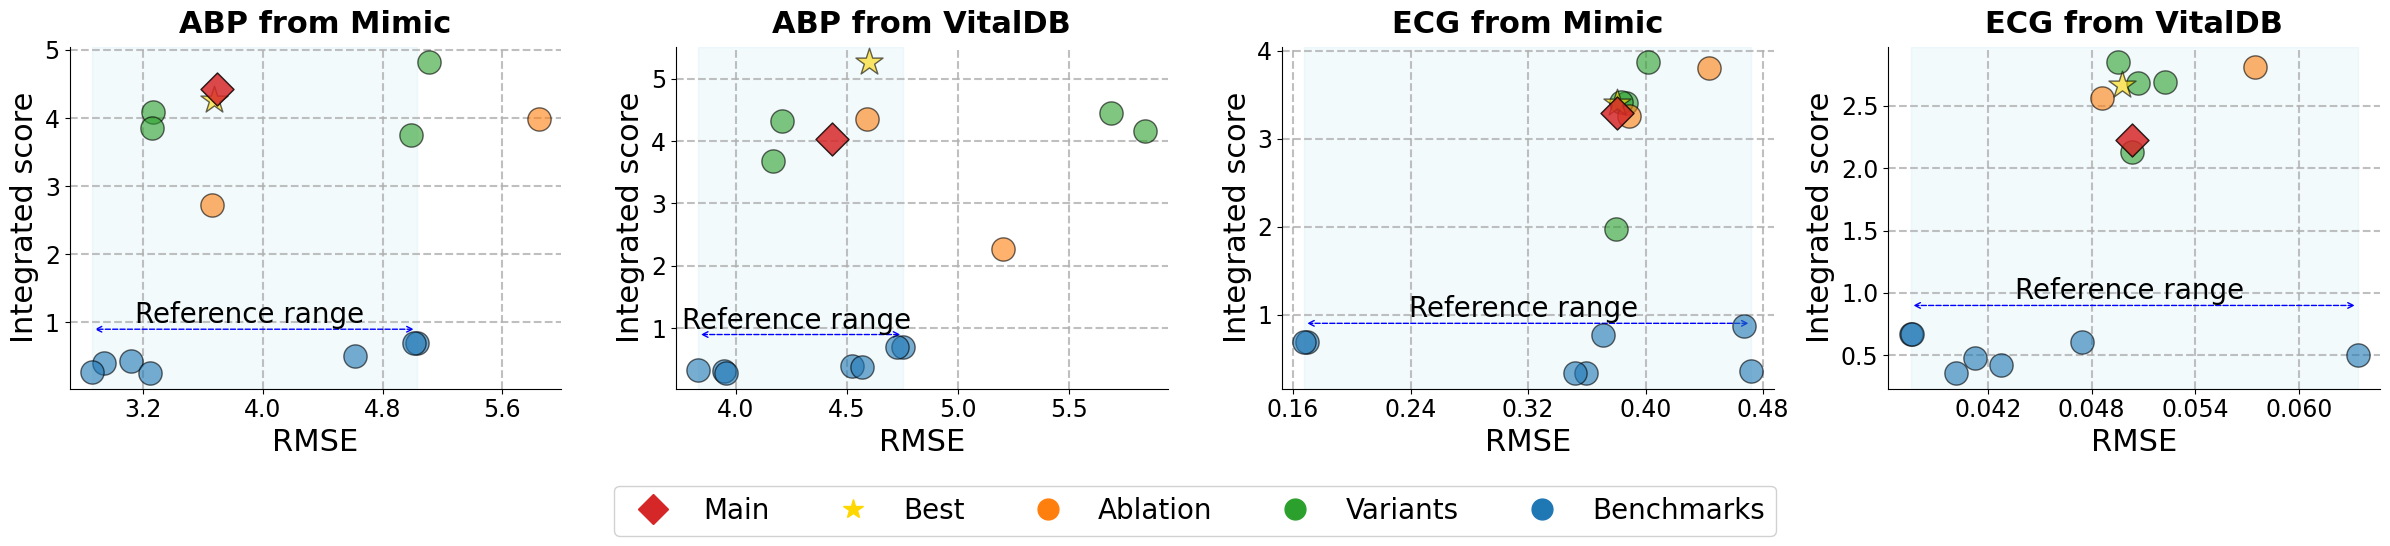

In [8]:
# -----------------------------------------------------------------------------
# 1. Define model lists and categorize each experiment
# -----------------------------------------------------------------------------
main_models = [
    'SKZFC_ART_1_30_800_Mimic',
    'SKZFC_ART_1_30_800_VitalDB',
    'SKZFC_II_1_30_800_Mimic',
    'SKZFC_II_1_30_800_VitalDB'
]

best_models = [
    'SKZFC_ART_1_50_800_Mimic',
    'SKZFC_ART_1_50_800_VitalDB',
    'SKZFC_II_1_50_800_Mimic',
    'SKZFC_II_1_50_800_VitalDB'
]

# Assign 'Category' for each table
SenseAccMItable['Category'] = 'Variants'
BenchAnalAccMItable['Category'] = 'Benchmarks'
AblaAccMItable['Category']   = 'Ablation'

Cols = ['Source', 'Type', 'Category', 'Model', 'RMSE', 'ISCORE']

# Concatenate all results, drop duplicates, and re-categorize Main/Best
AllModels = pd.concat([
    SenseAccMItable[~SenseAccMItable['Model'].isin(best_models)][Cols],
    BenchAnalAccMItable[~BenchAnalAccMItable['Model'].isin(best_models)][Cols],
    AblaAccMItable[Cols]
]).reset_index(drop=True).drop_duplicates().reset_index(drop=True)

AllModels.loc[AllModels['Model'].isin(main_models), 'Category'] = 'Main'
AllModels.loc[AllModels['Model'].isin(best_models), 'Category'] = 'Best'

# -----------------------------------------------------------------------------
# 2. Global style settings
# -----------------------------------------------------------------------------
FONT_SIZE         = 22
TITLE_FONT_SIZE   = 22
LEGEND_FONT_SIZE  = 20
TICK_LABEL_SIZE   = 17

# Define colors and markers for each Category
category_colors = {
    'Ablation':   'tab:orange',
    'Variants':   'tab:green',
    'Benchmarks': 'tab:blue',
    'Best':       'gold',
    'Main':       'tab:red'
}
DEFAULT_MARKER = 'o'
MAIN_MARKER    = 'D'
BEST_MARKER    = '*'

# -----------------------------------------------------------------------------
# 3. Set up a 1×N grid of subplots by (Type, Source)
# -----------------------------------------------------------------------------
unique_combinations = AllModels[['Type', 'Source']].drop_duplicates()
combinations        = unique_combinations.sort_values(by=['Type', 'Source']).values.tolist()

fig, axes = plt.subplots(1, len(combinations),
                         figsize=(6 * len(combinations), 5))
if len(combinations) == 1:
    axes = [axes]

# -----------------------------------------------------------------------------
# 4. Plot each subplot: scatter + benchmark‐range shading + range annotation
# -----------------------------------------------------------------------------
for ax, (t, s) in zip(axes, combinations):
    subset = AllModels[(AllModels['Type'] == t) & (AllModels['Source'] == s)]

    # 4.1 Shade the Benchmark RMSE range (no legend entry)
    bench = subset[subset['Category'] == 'Benchmarks']
    if not bench.empty:
        bmin, bmax = bench['RMSE'].min(), bench['RMSE'].max()
        ax.axvspan(bmin, bmax, color='skyblue', alpha=0.1, label='_nolegend_')

        # Annotate "<- range ->" with bidirectional arrows
        y_min, y_max = ax.get_ylim()
        y_pos = y_max - (y_max - y_min) * 0.1
        ax.annotate(
            '', xy=(bmin, y_pos), xytext=(bmax, y_pos),
            arrowprops=dict(arrowstyle='<->', linestyle='--', color='blue', lw=1. ),
            annotation_clip=False
        )
        ax.text(
            (bmin + bmax) / 2, y_pos, 'Reference range ',
            ha='center', va='bottom',
            fontsize=FONT_SIZE - 2, color='black'
        )

    # 4.2 Plot each Category, drawing 'Main' last so it’s on top
    cats = sorted(subset['Category'].unique(), key=lambda x: 1 if x == 'Main' else 0)
    for cat in cats:
        grp    = subset[subset['Category'] == cat]
        color  = category_colors.get(cat, 'gray')
        marker = MAIN_MARKER if cat == 'Main' else BEST_MARKER if cat == 'Best' else DEFAULT_MARKER

        marker_size = 420 if marker == '*' else 280

        ax.scatter(
            grp['RMSE'], grp['ISCORE'],
            color=color, marker=marker, s=marker_size, alpha=0.6,
            edgecolors='black', label=cat,
            zorder=10 if cat == 'Main' else 5
        )

    # 4.3 Axis titles, labels, and styling
    label_typ = 'ABP' if t == 'ART' else 'ECG' if t == 'II' else t
    ax.set_title(f"{label_typ} from {s}", fontsize=TITLE_FONT_SIZE,  pad=10, fontweight='bold')
    ax.set_xlabel('RMSE', fontsize=FONT_SIZE)
    ax.set_ylabel('Integrated score', fontsize=FONT_SIZE)
    ax.grid(True, linestyle='--', alpha=0.8, linewidth = 1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=TICK_LABEL_SIZE)

    # 4.4 Adjust x‐axis range with 5% padding
    if len(subset):
        rmse_vals = subset['RMSE'].values
        mn, mx    = rmse_vals.min(), rmse_vals.max()
        pad       = (mx - mn) * 0.05
        ax.set_xlim(mn - pad, mx + pad)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))

# -----------------------------------------------------------------------------
# 5. Build a single shared legend (excluding the range shading)
# -----------------------------------------------------------------------------
ordered_cats = ['Main', 'Best', 'Ablation', 'Variants', 'Benchmarks']
handles = []
for cat in ordered_cats:
    if cat in category_colors:
        mk = MAIN_MARKER if cat == 'Main' else BEST_MARKER if cat == 'Best' else DEFAULT_MARKER
        handles.append(
            mlines.Line2D([], [], color=category_colors[cat],
                          marker=mk, linestyle='None',
                          markersize=15, label=cat)
        )

fig.legend(
    handles, [h.get_label() for h in handles],
    title_fontsize=LEGEND_FONT_SIZE,
    fontsize=LEGEND_FONT_SIZE,
    loc='upper center', bbox_to_anchor=(0.5, 0.00),
    ncol=5, frameon=True, framealpha=0.9, fancybox=True
)

# -----------------------------------------------------------------------------
# 6. Final layout adjustments, save, and display
# -----------------------------------------------------------------------------
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('./PaperWork/Figures/IScoreRMSE.png', dpi=300, bbox_inches='tight')
plt.show()
